In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import alexnet
from torchvision.models import AlexNet_Weights
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.datasets.stl10 as stl10
# 加载预训练ResNet-18（PyTorch官方提供）
from torchvision.models import resnet18, ResNet18_Weights

In [4]:
# -------------------------- 1. 配置设备 --------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备：{device}")  # 正常输出"cuda:0"

使用设备：cuda:0


In [5]:
# -------------------------- 2. 数据加载与预处理 --------------------------
# 自定义STL10类，跳过原始压缩包的完整性校验（核心修改）
class STL10NoCheck(datasets.STL10):
    def _check_integrity(self):
        # 强制返回True，告诉torchvision"数据集是完整的"，跳过压缩包校验
        return True

# STL-10原始图像尺寸96×96，需放大到227×227（AlexNet输入尺寸）
# 训练集预处理：放大+数据增强（小数据集必须增强防过拟合）
train_transform = transforms.Compose([
    transforms.Resize(227),  # 96×96→227×227（放大，保持比例）
    transforms.RandomHorizontalFlip(p=0.5),  # 50%水平翻转
    transforms.RandomRotation(10),  # 随机旋转±10度
    transforms.ToTensor(),
    # STL-10常用标准化参数（像素值从0-1→-1到1，更稳定）
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 验证集预处理：仅放大和标准化（无增强，保证评估稳定）
val_transform = transforms.Compose([
    transforms.Resize(227),  # 同样放大到227×227
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载STL-10数据集（用自定义类，跳过校验）
data_root = "./data"  # 与你的data文件夹路径一致

# 训练集（本地加载，关闭下载，用自定义类跳过校验）
train_dataset = STL10NoCheck(
    root=data_root,
    split='train',
    download=False,  # 已手动准备数据，无需下载
    transform=train_transform
)

# 测试集（本地加载，关闭下载，用自定义类跳过校验）
val_dataset = STL10NoCheck(
    root=data_root,
    split='test',
    download=False,  # 已手动准备数据，无需下载
    transform=val_transform
)


# 数据加载器（优化num_workers，避免Windows多线程问题）
batch_size = 16  # 4060 8GB显存足够
# Windows系统建议num_workers=0（避免多线程报错），Linux/macOS可用4
num_workers = 0 if os.name == 'nt' else 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 训练集打乱
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # 验证集不打乱
    num_workers=num_workers
)

In [6]:
# 加载ImageNet预训练权重（会自动下载，约44MB）
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# 替换输出层为10类（STL-10）
num_ftrs = model.fc.in_features  # 获取最后一层全连接的输入特征数
model.fc = nn.Linear(num_ftrs, 10)  # 替换为10类输出

model = model.to(device)  # 移到GPU

In [7]:
# -------------------------- 4. 定义损失函数、优化器（适配小数据集） --------------------------
criterion = nn.CrossEntropyLoss()  # 分类任务标配

# 优化器：STL-10数据量小（5000张），初始学习率调低到0.001（避免快速过拟合）
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,  # 比ImageNet的0.01小，适合小数据集
    momentum=0.9,  # 保持动量加速收敛
    weight_decay=5e-4  # 权重衰减防过拟合
)

# 学习率调度器：每20个epoch衰减一次（STL-10训练快，衰减频率稍高）
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,  # 每20个epoch衰减
    gamma=0.1
)


In [8]:
# -------------------------- 5. 训练与验证循环 --------------------------
num_epochs = 60  # STL-10数据少，60个epoch足够（比ImageNet的90少）
best_acc = 0.0
save_path = "./alexnet_stl10.pth"  # 模型保存路径（明确标注STL-10）

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # 清空梯度
        outputs = model(inputs)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        # 每50个batch打印一次损失（STL-10的batch数少，50更合适）
        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss/50:.4f}")
            running_loss = 0.0

    # 更新学习率
    lr_scheduler.step()
    train_time = time.time() - start_time
    print(f"Epoch {epoch+1} 训练耗时：{train_time:.2f}秒")

    # 验证阶段
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1} 验证准确率：{val_acc:.2f}%")

    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"最佳模型已保存（准确率：{best_acc:.2f}%）")

print("训练完毕！")
print(f"最终最佳验证准确率：{best_acc:.2f}%")

Epoch [1/60], Batch [50/313], Loss: 1.7451
Epoch [1/60], Batch [100/313], Loss: 0.7737
Epoch [1/60], Batch [150/313], Loss: 0.4979
Epoch [1/60], Batch [200/313], Loss: 0.3819
Epoch [1/60], Batch [250/313], Loss: 0.3828
Epoch [1/60], Batch [300/313], Loss: 0.3505
Epoch 1 训练耗时：65.02秒
Epoch 1 验证准确率：93.35%
最佳模型已保存（准确率：93.35%）
Epoch [2/60], Batch [50/313], Loss: 0.2581
Epoch [2/60], Batch [100/313], Loss: 0.2341
Epoch [2/60], Batch [150/313], Loss: 0.2740
Epoch [2/60], Batch [200/313], Loss: 0.1991
Epoch [2/60], Batch [250/313], Loss: 0.2219
Epoch [2/60], Batch [300/313], Loss: 0.2026
Epoch 2 训练耗时：48.18秒
Epoch 2 验证准确率：95.20%
最佳模型已保存（准确率：95.20%）
Epoch [3/60], Batch [50/313], Loss: 0.1361
Epoch [3/60], Batch [100/313], Loss: 0.1534
Epoch [3/60], Batch [150/313], Loss: 0.1817
Epoch [3/60], Batch [200/313], Loss: 0.1653
Epoch [3/60], Batch [250/313], Loss: 0.1410
Epoch [3/60], Batch [300/313], Loss: 0.1744
Epoch 3 训练耗时：60.43秒
Epoch 3 验证准确率：95.03%
Epoch [4/60], Batch [50/313], Loss: 0.1145
Epoch

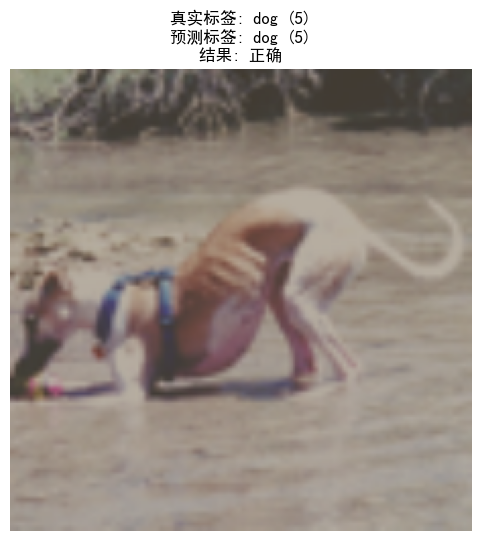

In [ ]:
# -------------------------- 6. 随机抽一张STL-10图片测试预测（修复类型错误） --------------------------
plt.rcParams["font.family"] = ["SimHei"]  
plt.rcParams["axes.unicode_minus"] = False  
dataset = val_dataset
if len(dataset) == 0:
    raise ValueError("验证集为空，请检查数据集加载是否正确！")

random_idx = random.randint(0, len(dataset) - 1)
img_tensor, true_label = dataset[random_idx]  # 注意：此时img已经是Tensor（因为val_dataset用了ToTensor()）

# 不需要再用val_transform处理（已经转换过了），直接增加批次维度并移到GPU
input_tensor = img_tensor.unsqueeze(0).to(device)  # 仅增加批次维度

# 加载最佳模型并预测
try:
    if not os.path.exists(save_path):
        raise FileNotFoundError(f"模型文件不存在：{save_path}")
    
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()
except Exception as e:
    print(f"模型加载失败：{str(e)}，使用当前模型演示")
    model.eval()

# 预测
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_label = torch.max(outputs, 1)
    predicted_label = predicted_label.item()

# STL-10类别名称
class_names = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# 显示结果（需要将Tensor转回PIL Image才能显示）
# 先反标准化（因为val_transform做了Normalize，直接显示会失真）
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],  # 反标准化公式：x = x*std + mean → 逆操作：x = (x - mean)/std
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()  # Tensor转PIL Image
])
img_pil = inv_transform(img_tensor)  # 转换为可显示的图片

plt.figure(figsize=(6, 6))
plt.imshow(img_pil)
is_correct = predicted_label == true_label
title_text = (
    f"真实标签: {class_names[true_label]} ({true_label})\n"
    f"预测标签: {class_names[predicted_label]} ({predicted_label})\n"
    f"结果: {'正确' if is_correct else '错误'}"
)
plt.title(title_text)
plt.axis("off")
plt.show()